In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from utils import get_logicals
import stim
from scipy.sparse import lil_matrix
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
# %load_ext snakeviz

In [50]:
GF = galois.GF(2)
ccode = read_code("./codes/12_9_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[1 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0]
 [0 0 1 1 0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 1]
 [0 1 1 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 1 1 1 0 0 1 0 0]
 [1 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 1]]
3


(108, 225)


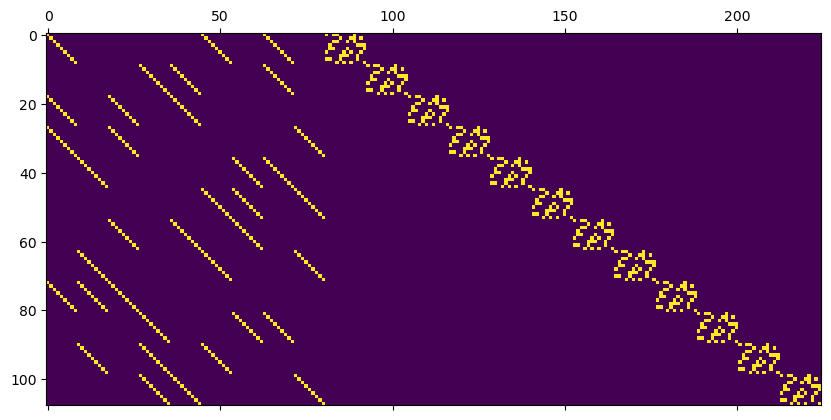

In [51]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
Hz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
Hx = dE1

m, n = Hx.shape

print(Hz.shape)
plt.matshow(Hz)

In [52]:
zL = get_logicals(Hx, Hz, False)
xL = get_logicals(Hx, Hz, True)
print(len(zL))

9


In [53]:
data_qbts = np.arange(n)
x_checks = np.arange(n,n+m)
z_checks = np.arange(n+m,n+m+m)
all_qbts = np.arange(n+m+m)
curr_data_qbts = np.arange(n)
curr_pos = {i: i for i in range(n)}

def prepare_x_checks(checks):
    c = stim.Circuit()
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-6)
    for x in checks:
        gen_qbts = data_qbts[np.where(Hx[x])[0]]
        for qbt in gen_qbts:
            path_qbts = [x_checks[x], curr_pos[qbt]]
            c.append("CNOT", path_qbts)
            c.append("DEPOLARIZE2", path_qbts, 1e-4)
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-6)
    return c

def prepare_z_checks(checks):
    c = stim.Circuit()
    for z in checks:
        gen_qbts = data_qbts[np.where(Hz[z])[0]]
        for qbt in gen_qbts:
            path_qbts = [curr_pos[qbt], z_checks[z]]
            c.append("CNOT", path_qbts)
            c.append("DEPOLARIZE2", path_qbts, 1e-4)
    return c


class Simulation:
    def __init__(self, num_rounds, p_mask, stab_type):
        self.num_rounds = num_rounds
        self.p_mask = p_mask
        self.stab_type = stab_type

        self.prev_meas_z = np.zeros(m, dtype=int)
        self.prev_meas_x = np.zeros(m, dtype=int)
        self.curr_meas_z = np.zeros(m, dtype=int)
        self.curr_meas_x = np.zeros(m, dtype=int)

        self.route_confirmation_z = np.ones(m, dtype=int)
        self.route_confirmation_x = np.ones(m, dtype=int)
        self.z_detector_history = np.ones(m)
        self.x_detector_history = np.ones(m)

        self.c = stim.Circuit()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(m)).without_noise()
            # self.c.append("X_ERROR", z_checks, 1e-4)
            for i, z_check in enumerate(np.arange(m)):
                self.c.append("MR", z_checks[z_check])
                self.prev_meas_z[z_check] = self.c.num_measurements
            # self.c.append("X_ERROR", z_checks, 1e-5)
        else:
            self.c += prepare_x_checks(np.arange(m)).without_noise()
            # self.c.append("X_ERROR", x_checks, 1e-4)
            for i, x_check in enumerate(np.arange(m)):
                self.c.append("MR", x_checks[x_check])
                self.prev_meas_x[x_check] = self.c.num_measurements
            # self.c.append("X_ERROR", x_checks, 1e-5)

    def detectors(self, stab_type):
        num_meas = self.c.num_measurements
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z
        curr_meas = self.curr_meas_x if stab_type else self.curr_meas_z

        for i, check in enumerate(curr_meas):
            if check:
                if not prev_meas[i]:
                    self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1)])
                else:
                    self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1), stim.target_rec(prev_meas[i]-num_meas-1)])
                prev_meas[i] = curr_meas[i]
                curr_meas[i] = 0

        if stab_type:
            self.prev_meas_x = prev_meas
            self.curr_meas_x = curr_meas
        else:
            self.prev_meas_z = prev_meas
            self.curr_meas_z = curr_meas

    def final_detectors(self, stab_type):
        num_meas = self.c.num_measurements
        H = Hx if stab_type else Hz
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z

        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = [j-n for j in incl_qbts]
            target_recs = [stim.target_rec(j) for j in incl_qbts]

            if prev_meas[i]:
                target_recs.append(stim.target_rec(prev_meas[i]-num_meas-1))
            self.c.append("DETECTOR", target_recs)

    def observables(self, stab_type):
        for i, logical in enumerate(xL if stab_type else zL):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-n for j in incl_qbts]
            self.c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)

    def round(self):
        def measure_z_checks(curr_z_checks):
            self.c += prepare_z_checks(curr_z_checks).without_noise()
            # self.c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], 1e-4)
            for i, z_check in enumerate(curr_z_checks):
                self.c.append("M", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements
            for i, z_check in enumerate(z_checks):
                self.c.append("R", z_check)
            # self.c.append("X_ERROR", z_checks, 1e-5)

        def measure_x_checks(curr_x_checks):
            self.c += prepare_x_checks(curr_x_checks).without_noise()
            # self.c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], 1e-4)
            for i, x_check in enumerate(curr_x_checks):
                self.c.append("M", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements
            for i, x_check in enumerate(x_checks):
                self.c.append("R", x_check)
            # self.c.append("X_ERROR", x_checks, 1e-5)

        curr_z_checks = np.arange(m)[self.route_confirmation_z==1]
        curr_x_checks = np.arange(m)[self.route_confirmation_x==1]

        if self.stab_type:
            measure_x_checks(curr_x_checks)
            measure_z_checks(curr_z_checks)
        else:
            measure_z_checks(curr_z_checks)
            measure_x_checks(curr_x_checks)


    def simulate(self):
        for i in range(1, self.num_rounds+1):
            self.c.append("X_ERROR", [qbt for qbt in all_qbts], 0.01)  # idle errors

            self.route_confirmation_z = np.array([1 if np.random.random() < self.p_mask else 0 for z in z_checks])
            self.route_confirmation_x = np.array([1 if np.random.random() < self.p_mask else 0 for x in x_checks])

            self.z_detector_history = np.vstack([self.z_detector_history, self.route_confirmation_z])
            self.x_detector_history = np.vstack([self.x_detector_history, self.route_confirmation_x])

            self.round()
            self.detectors(self.stab_type)

        if self.stab_type: self.c.append("H", [qbt for qbt in data_qbts])
        # self.c.append("X_ERROR", [qbt for qbt in data_qbts], 1e-4)
        self.c.append("M", [curr_pos[qbt] for qbt in data_qbts])
        self.final_detectors(self.stab_type)
        self.observables(self.stab_type)


In [54]:
s = Simulation(10, 1, False)
s.simulate()
c = s.c

In [55]:
sampler = c.compile_detector_sampler()
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.bool_)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.bool_)

errors = []
channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=100, #pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=min(pcm.shape[0],10) #the osd search depth
)

successes = 0
for ii in tqdm(range(1000)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2
    success = np.all(observable_flips[0].astype(int) == guessed_obs)
    successes += success

successes

(1188, 3330)
(9, 3330)


100%|██████████| 1000/1000 [00:04<00:00, 220.48it/s]


943

In [45]:
successes

1000

In [27]:
pcm.shape

(432, 4473)